### CIFAR-10 Using Pytorch

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


import numpy as np

In [2]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [41]:
# torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [42]:
for images,labels in train_loader:
    break

In [43]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [6 7 4 6 3 9 3 4 5 7]
Class:  frog horse  deer  frog   cat truck   cat  deer   dog horse


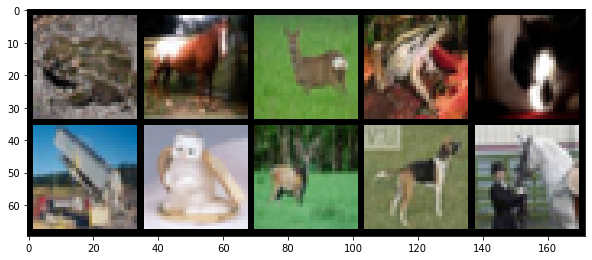

In [46]:
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [59]:
X_train.shape

torch.Size([10, 3, 32, 32])

In [70]:
class convnet(nn.Module):
    
    def __init__(self):
        super().__init__()
        # input dims - (b,32,32,3)
        self.conv3_32 = nn.Conv2d(3, 32, 3, 1) # channels_in =3, # filters = 32 (3,3) stride =1
        self.conv32_32 = nn.Conv2d(32,32, 3, 1) # channels_in =16, # filters = 32 (3,3) stride =1
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.drop_4 = nn.Dropout2d(p=0.4)
        self.conv32_64 = nn.Conv2d(32,64,3,1)
        self.conv64_64 = nn.Conv2d(64,64,3,1)
        self.fc1 = nn.Linear(5*5*64,512)
        self.drop_5 = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(512,10)
        
    
    def forward(self,X):
        
        X = F.relu(self.conv3_32(X)) # dims 32,32,3 c-> 30,30,32 
        X = F.relu(self.conv32_32(X)) # 30,30,32 c-> 28,28,32
        X = self.pool(X) # 15,15,32 
        X = self.drop_4(X)
        
        X = F.relu(self.conv32_64(X)) # 13,13,64
        X = F.relu(self.conv64_64(X)) # 11,11,64
        X = self.pool(X) # 5,5,64
        X = self.drop_4(X)
        
        X = X.view(-1,5*5*64)

        X = F.relu(self.fc1(X))
        X = self.drop_5(X)
        X = F.relu(self.fc2(X))
        
        return F.log_softmax(X, dim=1)

        
        
        
        
        
        

        

In [71]:
model = convnet()
model

convnet(
  (conv3_32): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv32_32): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop_4): Dropout2d(p=0.4, inplace=False)
  (conv32_64): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv64_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (drop_5): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [72]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [73]:
count_parameters(model)

   864
    32
  9216
    32
 18432
    64
 36864
    64
819200
   512
  5120
    10
______
890410


In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [76]:
import time
start_time = time.time()

epochs = 30
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

epoch:  0  batch: 1000 [ 10000/50000]  loss: 2.30258536  accuracy:  10.010%


KeyboardInterrupt: 